In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
from graphviz import Digraph

# Helper function che serve per ottenere tutti gli edge e i node presenti nel graph partendo dal nodo di root
def trace(root):
    
    # inizializza i set vuoti
    nodes, edges = set(), set()
    
    # Funzione ricorsiva che, dato un nodo, ne estre i children e li aggiunge ai set di Edge e Node
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    # Chiamata iniziale alla funzione ricorsiva
    build(root)
    return nodes, edges

# Funzione che richiama l'API di Graphviz per disegnare il grafo con i nodi e gli edge che compongono la funzione
#
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    
    # Chiamo Helper Function per estrarre gli edge e i node
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
#        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
#        dot.node(name=str(id(n)), label = "{ data %.4f }" % (n.data), shape='record')
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

Vediamo adesso come eseguire la backprop su un neural network (MLP).<br>
Si utilizza un rappresentazione matematica del funzionamento dei neuroni

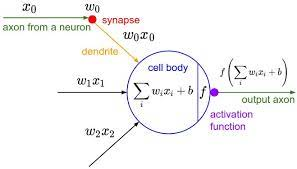

Ogni neurone riceve una serie di input, per ogni input c'è un weight che viene moltiplicato x l'input. <br>Alla somma(dot product) di tutti i (input * weight) viene aggiunto un bias e il risultato viene dato in input ad una activation function (di solito una squachinh function come sigmoid o relu)

Proviamo a vedere come funzione un neuron, definendo gli step di un forward pass per un neuron con 2 input

In [72]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
#b = Value(8, label='b')
# Per facilitare i calcoli inizializzo bias ad un valore che successivamente facilita i calcoli
b = Value(6.8812735870195432, label='b')

# x1*w1 +x2*w2 +b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n= x1w1x2w2 +b; n.label = 'n'

# In questo modo otteniamo il risultato prima dell'activation

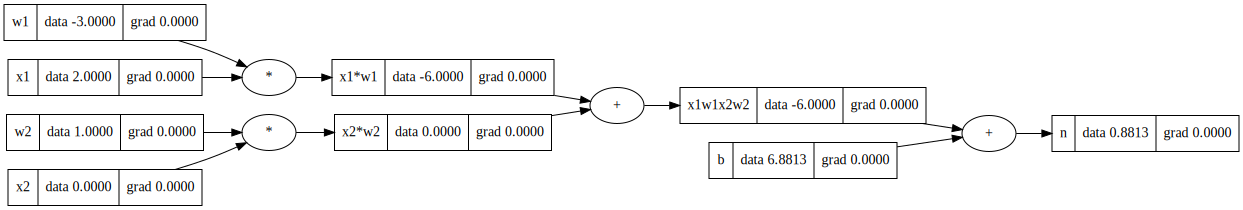

In [73]:
draw_dot(n)

Ora è necessario applicare tanh al risultato ottenuto 
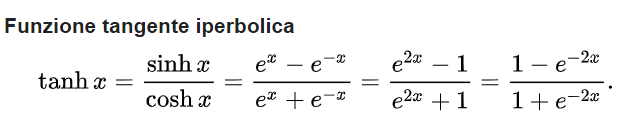

e pertanto è necessario implementare la classe Value() per gestire l'operazione di exponentiation.
Ci sarebbero 2 opzioni:
- implementare ogni operazione alla base di tanh (sottrazione, divisione, elevazione ad espondente)
- implementare l'operazione di tanh come operazione "composta".


La cosa importante è poi sia possibile calcolarne la local derivative

In [74]:
class Value:
    
    # Costruttore
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        
        self.grad = 0.0    # Inizializzato a 0
        
        self._prev = set(_children) # viene tenuto il set per ragioni di efficienza
        self._op = _op
        self.label = label
        
    # Metodo utilizzato da Python per la visualizzazione dell'oggetto. Consente di impostare un visualizzazione user friendly
    def __repr__(self):
        return f"Value(data={self.data})"
    
    # Definisce l'operatore per la somma (+). Quando trova l'operatore +, Python chiama questo metodo
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    # Definisce l'operatore per la prodottp (*). Quando trova l'operatore *, Python chiama questo metodo
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        return out
    

In [75]:
o = n.tanh(); o.label = 'o'

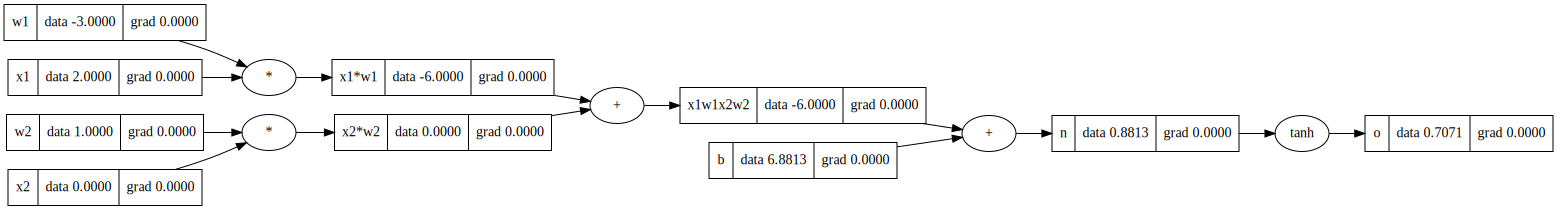

In [76]:
draw_dot(o)

A questo punto è possibile iniziare la backpropagation calcolando manualmente le partial derivative in modo da riuscire ad ottenere la detivata di o rispetto a tutti i valori del NN. In particolare saremo interessati a calcolare i gradient rispetto a w1 e w2,

Iniziamo dal gradient di o rispetto ad o: sappiamo che è uguale a 1

In [77]:
o.grad = 1.0

Ora dobbiamo calcolare la derivata di tanh().

Sappiamo che
o = tanh(n)
Utilizzando una regola di calculus, sappiamo la formula per calcolare la derivata di che ci interessa
do/dn = 1 - tanh(n)**2
1 - o**2

In [78]:
1 - o.data**2

0.5000707131778828

Da ciò si deduce che la local derivative di tanh(n) è = 0.5

In [79]:
n.grad = 0.5

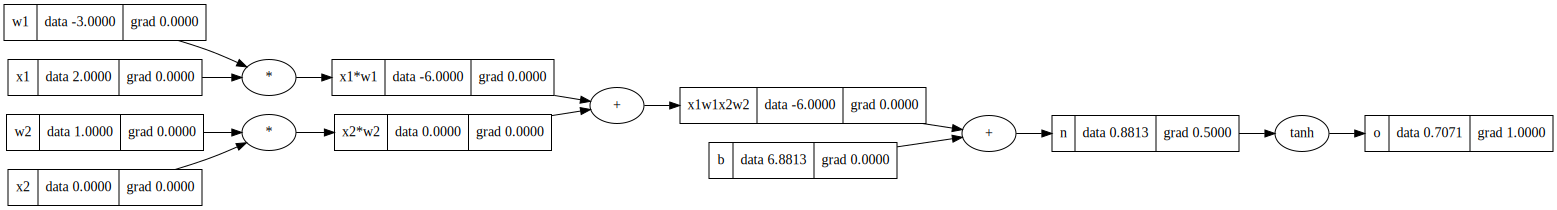

In [80]:
draw_dot(o)

Dobbiamo continuare backprop attraverso di nodo "+". Abbiamo visto nell'esempio precedente che il nodo "+" distribuisce il gradient precedente in quanto la sua local derivative è sempre = 1. Pertanto il gradient viene distribuito ai nodi "children".

In [81]:
b.grad = 0.5
x1w1x2w2.grad = 0.5

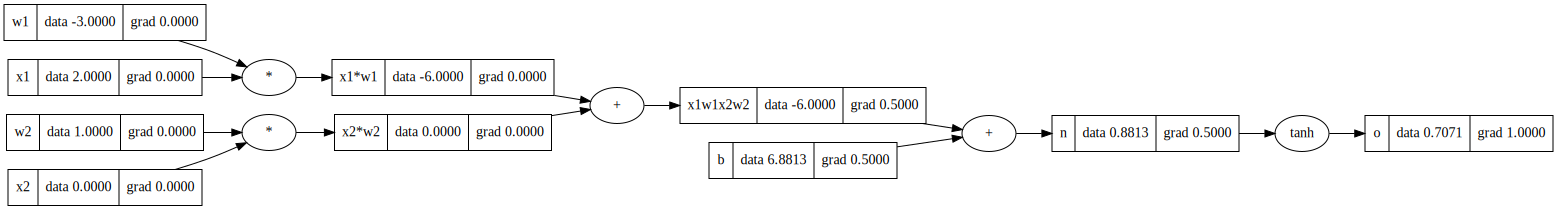

In [82]:
draw_dot(o)

Step successivo della backprop transita ancora da un nodo "+" per cui anche in questo caso il gradient transita immutato ai nodi children

In [83]:
x1w1.grad = 0.5
x2w2.grad = 0.5

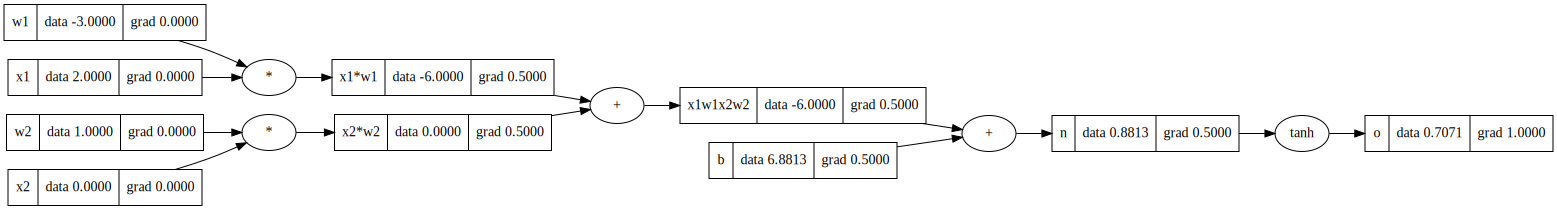

In [84]:
draw_dot(o)

Ora abbiamo 2 nodi "moltiplicazione" e sappiamo dall'esempio precedente che la local derivative di una moltiplicazione per ogni fattore corrisponde all'altro fattore del prodotto. Quindi, applicando la chain rule, la derivata del valore rispetto all'output finale è uguale alla local derivative moltiplicata x la derivata del nodo precedente.

In [89]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [90]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

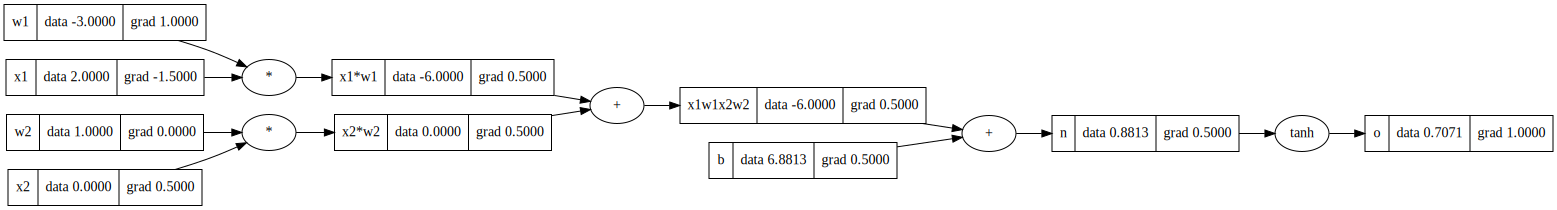

In [91]:
draw_dot(o)

Una volta conclusa la backprop, sappiamo che se volgliamo incrementare il valore finale dell'output (o), dovremo incrementare il valore di w1. Infatti la derivata di w1 rispetto a o è 1 (quindi è positiva) e quindi ad un aumento di x1 corrisponde un aumento di o.<br> w2 invece, avendo derivata = 0, è ininfluente sul risultato finale

Ovviamente non è possibile implementare questo meccanismo di backprop manualemente: è necessario un meccanismo automatico di backprop